# Imports

Following this tutorial for using kaggle with colab: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html.

Following this tutorial for the data processing and DCGAN: https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432

Repo for above ^ tutorial: https://github.com/JadeBlue96/DCGAN-Dog-Generator.git

Also following this tutorial for the DCGAN: https://www.tensorflow.org/tutorials/generative/dcgan

In [1]:
#!pip install keras==2.3.1 # https://stackoverflow.com/questions/63062833/no-module-named-keras-legacy?scrlybrkr
#!pip install tensorflow==2.1.0 # https://stackoverflow.com/questions/61137954/attributeerror-module-tensorflow-python-keras-utils-generic-utils-has-no-attr

In [2]:
!pip install kaggle # will be using the stanford dogs dataset with kaggle 

In [3]:
import numpy as np # for np arrays
import matplotlib.pyplot as plt, zipfile # creating plots

from pathlib import Path # directories as OOP
import os # file reading
import xml.etree.ElementTree as ET # for parsing annotations 
import cv2 # for reading the image

import math
import random

import time
import datetime

from tqdm import tqdm, tqdm_notebook # progress bar

import tensorflow as tf # for the model

import json # for keras api key

# Setting up Keras

In [10]:
!ls -a

.  ..  .config	.kaggle  sample_data


In [11]:
!mkdir .kaggle
!ls -a

mkdir: cannot create directory ‘.kaggle’: File exists
.  ..  .config	.kaggle  sample_data


In [17]:
username = "flynnick"
api_key = "74bc7ceb6d32c60199e4f43c993fd206" # yes I know this shouldn't be in the repo

token = {"username": username,"key": api_key} # secret

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [18]:
!chmod 600 /content/.kaggle/kaggle.json # read + write allowed

In [19]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [20]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [21]:
!kaggle competitions download -c generative-dog-images -p /content # download stanford dog dataset

 98% 724M/739M [00:05<00:00, 94.3MB/s]
100% 739M/739M [00:05<00:00, 130MB/s] 
 54% 9.00M/16.8M [00:00<00:00, 29.0MB/s]
100% 16.8M/16.8M [00:00<00:00, 48.4MB/s]


# Data Preparation

In [22]:
!unzip \*.zip # unzip dataset

Streaming output truncated to the last 5000 lines.
  inflating: Annotation/n02088094-Afghan_hound/n02088094_4501  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_4501  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_13442  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_13442  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_8764  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_8764  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_3982  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_3982  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_3949  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_3949  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_1410  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_1410  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_1841  
  inflating: __MACOSX/Annotation/n02088094-Afghan

In [23]:
!ls -a

.   all-dogs	  Annotation	  .config  __MACOSX
..  all-dogs.zip  Annotation.zip  .kaggle  sample_data


In [24]:
img_width = 64 # width we will be resizing images to
img_height = 64 # height we will be resizing images to
img_color_channels = 3 # rgb
img_sample_size = 10000
img_output_dir = '/output_images/'
img_input_dir = '/content/all-dogs/'
img_ann_dir = "/content/Annotation/"
OUT_DIR = Path('/output_images/')
TRAIN_DIR = Path('/content/all-dogs')

In [25]:
dog_breed_dict = {}
for annotation in os.listdir(img_ann_dir):
  # annotations follow the format:
  # image_name-breed_name
  annotations = annotation.split('-')
  dog_breed_dict[annotations[0]] = annotations[1]

In [26]:
print(dog_breed_dict)

{'n02095889': 'Sealyham_terrier', 'n02094258': 'Norwich_terrier', 'n02101556': 'clumber', 'n02100583': 'vizsla', 'n02111277': 'Newfoundland', 'n02086910': 'papillon', 'n02112706': 'Brabancon_griffon', 'n02110958': 'pug', 'n02106662': 'German_shepherd', 'n02089973': 'English_foxhound', 'n02112137': 'chow', 'n02090721': 'Irish_wolfhound', 'n02108000': 'EntleBucher', 'n02116738': 'African_hunting_dog', 'n02088238': 'basset', 'n02110806': 'basenji', 'n02113624': 'toy_poodle', 'n02110627': 'affenpinscher', 'n02099429': 'curly', 'n02112018': 'Pomeranian', 'n02091134': 'whippet', 'n02105162': 'malinois', 'n02088094': 'Afghan_hound', 'n02097658': 'silky_terrier', 'n02093754': 'Border_terrier', 'n02085936': 'Maltese_dog', 'n02088466': 'bloodhound', 'n02102040': 'English_springer', 'n02096437': 'Dandie_Dinmont', 'n02097474': 'Tibetan_terrier', 'n02110185': 'Siberian_husky', 'n02090622': 'borzoi', 'n02085782': 'Japanese_spaniel', 'n02112350': 'keeshond', 'n02089867': 'Walker_hound', 'n02100236': 

In [27]:
def read_image(img_path):
  '''Reads and transforms an image to RGB.'''
  img = cv2.imread(img_path)
  if img is None:
    raise FileNotFoundError
  else: # technically unnecessary else statement
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [28]:
def load_cropped_images(dog_breed_dict=dog_breed_dict, img_ann_dir=img_ann_dir, sample_size=25000, img_width=img_width, img_height=img_height, img_channels=img_color_channels):
  """
  Loads all the dog images, crops, and resizes them.
  This is the bulk of where the data processing occurs.
  """
  i = 0 # indexing variable
  breeds = []
  # sample size is the number of dogs
  dog_images_np = np.zeros((sample_size, img_width, img_height, img_channels))
  for breed_folder in os.listdir(img_ann_dir):
    for dog_ann in tqdm(os.listdir(img_ann_dir + breed_folder)):
      try:
        img = read_image(os.path.join(img_input_dir, dog_ann + '.jpg')) # read image
      except FileNotFoundError:
        continue
                
      tree = ET.parse(os.path.join(img_ann_dir + breed_folder, dog_ann)) # get the annotations for this image
      root = tree.getroot()
            
      size = root.find('size')
      width = int(size.find('width').text)
      height = int(size.find('height').text)
      objects = root.findall('object')

      for dog in objects: # some images contain multiple dogs, hence objects plural
        bndbox = dog.find('bndbox') # the bounding box around the dog
                
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
                
        xmin = max(0, xmin - 4) # add a margin of 4
        xmax = min(width, xmax + 4) # add a margin of 4
        ymin = max(0, ymin - 4) # add a margin of 4
        ymax = min(height, ymax + 4) # add a margin of 4

        # I am honestly unsure why we are adding a margin of 4, but that is what the code I am following does

        w = np.min((xmax - xmin, ymax - ymin)) # we are cropping these to squares, so we want to use the smaller dimension
        w = min(w, width, height) # this is just to be safe (perhaps the bounding box extends past the image)

        if w > xmax - xmin:
          xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
          xmax = xmin + w
        if w > ymax - ymin:
          ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
          ymax = ymin + w
        
        img_cropped = img[ymin:ymin+w, xmin:xmin+w, :] # [h,w,c]

        # all of the above was to crop the image to just include the dog
        # below is to resize the image to the dimensions we want (img_width and img_height)

        # determine interpolation method
        if xmax - xmin > img_width:
            interpolation = cv2.INTER_AREA # we need to shrink
        else:
            interpolation = cv2.INTER_CUBIC # we need to expand
            
        img_resized = cv2.resize(img_cropped, (img_width, img_height), 
                                interpolation=interpolation) # resize image
            
        dog_images_np[i,:,:,:] = np.asarray(img_resized)
        # annotations follow the format:
        # image_name-breed_name
        dog_breed_name = dog_breed_dict[dog_ann.split('_')[0]] # get the breed name using the image name
        breeds.append(dog_breed_name)
        i += 1
                
  return dog_images_np, breeds

In [29]:
start = time.time()
# the person who did this originally found there to be exactly 22125 dogs
# which helps in creating our np array of fixed size
print("LOADING IMAGES...")
dog_images_np, breeds = load_cropped_images(sample_size=22125)
# dog_images_np is the input data, breeds are the labels we are trying to predict
rounded_time = round(time.time() - start)
print(f"\nImage loading, cropping, and resizing time: {datetime.timedelta(seconds=rounded_time)}.")

LOADING IMAGES...


100%|██████████| 197/197 [00:00<00:00, 296.33it/s]


Image loading, cropping, and resizing time: 0:01:10.


In [30]:
def plot_features(features, labels, img_width=img_width, img_height=img_height, img_channels=img_color_channels, examples=16, disp_labels=True): 
  """Plots some dog images and their corresponding breeds."""
  if not math.sqrt(examples).is_integer():
    print('Please select a valid number of examples (must be a perfect square).')
    return
  imgs = []
  classes = []
  for i in range(examples):
    rnd_idx = np.random.randint(0, len(labels))
    imgs.append(features[rnd_idx, :, :, :])
    classes.append(labels[rnd_idx])

  fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)), figsize=(15,15),
  subplot_kw = {'xticks':[], 'yticks':[]},
  gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
  for i, ax in enumerate(axes.flat):
    if disp_labels == True:
      ax.title.set_text(classes[i])
    ax.imshow(imgs[i])

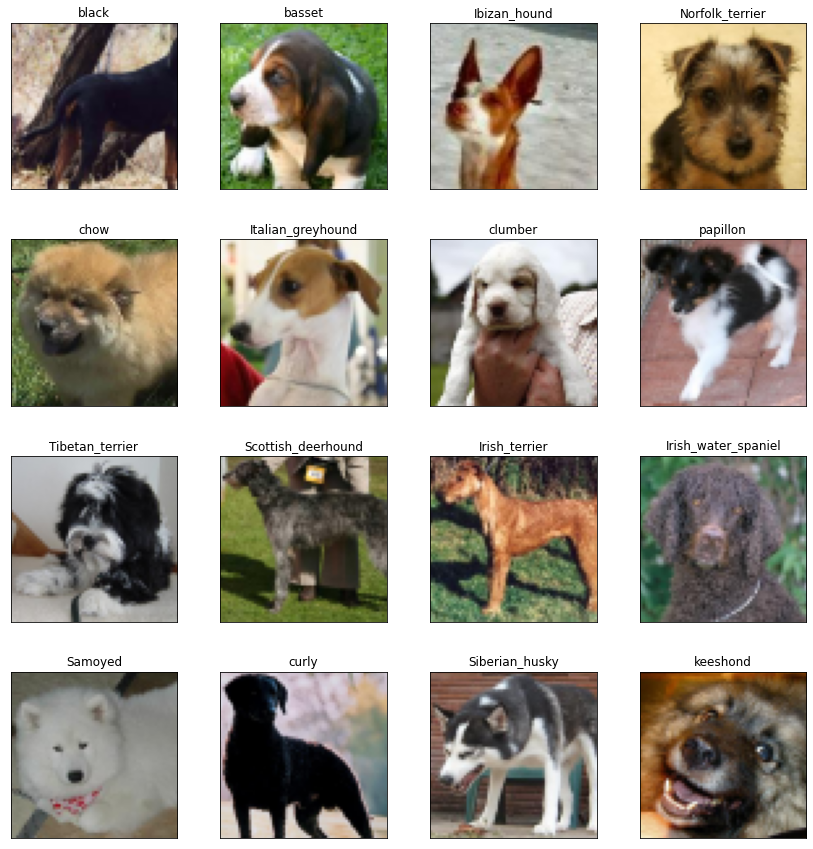

In [31]:
plot_features(dog_images_np / 255., breeds, examples=16, disp_labels=True)

# NOTE: dog_images_np / 255. normalizes the pixel range to [0, 1]

# Something else to note is that because we are cropping the images into squares,
# sometimes we only get part of the dog,
# like only the butt of the dog in the top left corner

In [32]:
sample_size = 22125
batch_size = 128


dog_images_np = (dog_images_np - (255/2)) / (255/2)  # normalize the pixel range to [-1, 1], because I will be using tanh for my output, which has the range [-1, 1]

dog_features_tf = tf.cast(dog_images_np, 'float32') # create tf dataset object

# some data augmentation
def flip(x: tf.Tensor) -> (tf.Tensor):
    x = tf.image.random_flip_left_right(x) # 50% img will be flipped
    return x

# shuffle, flip 50% of images, and separate into batches
dog_features_data = tf.data.Dataset.from_tensor_slices(dog_features_tf).shuffle(sample_size).map(flip).batch(batch_size, drop_remainder=True)

# Model Building

In [33]:
# Necessary tf imports

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape,\
Conv2DTranspose, Conv2D, Flatten, Dropout, Embedding, ReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

In [34]:
# a bunch of hyperparameters that were pretuned (some of these are for the generator, some for the descriminator)

sample_size = 22125 # number of images
batch_size = 128

weight_init_std = 0.02 # for "stabalizing model training"
weight_init_mean = 0.0 # for "stabalizing model training"

leaky_relu_slope = 0.2

dropout_rate = 0.5

downsize_factor = 2
scale_factor = 4 ** downsize_factor # reshapes generator's noise vector to (4, 4, 512)

# params for learning rate
lr_initial_d = tf.Variable(0.0002)
lr_initial_g = tf.Variable(0.0002)
lr_decay_steps = 1000

noise_dim = 128

In [35]:
weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=42)

In [86]:
# Template layers so I don't have to keep on rewriting the same code.

# for the generator
def transposed_conv(model, out_channels, kernel_size, stride_size, ptype='same'):
    model.add(Conv2DTranspose(out_channels, (kernel_size, kernel_size), 
                              strides=(stride_size, stride_size), 
                              padding=ptype, kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    return model

# for the discriminator
def conv(model, out_channels, ksize, stride_size):
    model.add(Conv2D(out_channels, (ksize, ksize), strides=(stride_size, stride_size), padding='same', 
                     kernel_initializer=weight_initializer, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_relu_slope))
    model.add(Dropout(dropout_rate))
    return model

In [97]:
def WoofGenerator():
  model = Sequential()

  model.add(Dense(img_width // scale_factor * img_height // scale_factor * 128,
                  input_shape=(noise_dim,), kernel_initializer=weight_initializer))
  model.add(Reshape((img_height // scale_factor, img_width // scale_factor, 128)))
  
  # using the helper functions
  model = transposed_conv(model, 512, kernel_size=5, stride_size=1)
  model = transposed_conv(model, 256, kernel_size=5, stride_size=2)
  model = transposed_conv(model, 128, kernel_size=5, stride_size=2)
  model = transposed_conv(model, 64, kernel_size=5, stride_size=2)
  model = transposed_conv(model, 32, kernel_size=5, stride_size=2)
  
  model.add(Dense(img_color_channels, activation='tanh', kernel_initializer=weight_initializer))

  return model

In [98]:
dog_generator = WoofGenerator()
print(dog_generator.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 2048)              264192    
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization_24 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 256)       

Just as a sanity check, it makes sense that the final output has the dimensions (None, 64, 64, 3), because we are generating images of dimensions 64x64 and the 3 channels for RGB.

In [99]:
def WoofDiscriminator():
  model = Sequential()

  model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', use_bias=False, 
                   input_shape=[img_height, img_width, img_color_channels],  
                   kernel_initializer=weight_initializer))
  model.add(LeakyReLU(alpha=leaky_relu_slope))

  # using the helper functions
  model = conv(model, 64, ksize=4, stride_size=2)
  model = conv(model, 128, ksize=4, stride_size=2)
  model = conv(model, 256, ksize=4, stride_size=2)

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  return model

In [100]:
dog_discriminator = WoofDiscriminator()
print(dog_discriminator.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 64)        3072      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        65536     
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 128)       

Just as a sanity check, it makes sense that the final output has the dimensions (None, 1), because the descriminator is a binary classifier.

In [52]:
generator_optimizer = Adam(learning_rate=lr_initial_g)
discriminator_optimizer = Adam(learning_rate=lr_initial_d)

In [106]:
# Helper function for loss functions in next cell

def noisy_labels(y, p_flip):
  """Randomly flips some labels."""
  # determine the number of labels to flip
  n_select = int(p_flip * int(y.shape[0]))
  # choose labels to flip
  flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
  output_list = []
  for i in range(int(y.shape[0])):
    if i in flip_ix:
      output_list.append(tf.subtract(1, y[i]))
    else:
      output_list.append(y[i])
    
  outputs = tf.stack(output_list)
  return outputs

In [109]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def woof_generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def woof_discriminator_loss(real_output, fake_output):

  # randomly flip some labels
  #real_output_noisy = noisy_labels(tf.ones_like(real_output), 0.05)
  #fake_output_noisy = noisy_labels(tf.zeros_like(fake_output), 0.05)

  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # compares predictions of dataset images to arr of 1s
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # compares predictions of generated images to arr of 0s 
  return real_loss + fake_loss

In [55]:
# so we can save our model!

checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=dog_generator,
                                 discriminator=dog_discriminator)

In [56]:
EPOCHS = 280
num_examples_to_generate = 64
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Model Training

In [62]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = dog_generator(noise, training=True)

    real_output = dog_discriminator(images, training=True)
    fake_output = dog_discriminator(generated_images, training=True)

    gen_loss = woof_generator_loss(fake_output)
    disc_loss = woof_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, dog_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dog_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, dog_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dog_discriminator.trainable_variables))

  return gen_loss, disc_loss

In [58]:
def generate_and_save_images(model, epoch, test_input, rows, cols):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(14,14))
  for i in range(predictions.shape[0]):
    plt.subplot(rows, cols, i+1)
    plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.) # * (127.5 + 127.5) / 255 to normalize [0, 1]
    plt.axis('off') 
      
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def generate_test_image(model, noise_dim=noise_dim):
  test_input = tf.random.normal([1, noise_dim])
  prediction = model(test_input, training=False)
  fig = plt.figure(figsize=(5,5))
  plt.imshow((prediction[0, :, :, :] * 127.5 + 127.5) / 255.)
  plt.axis('off') 
  plt.show()

In [63]:
def train(dataset, epochs):
  """Where all the magic happens!"""
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # produce images for the GIF as you go (to see it improving)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [110]:
print("Let's see the magic happen!")
train(dog_features_data, EPOCHS)

Let's see the magic happen!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


ValueError: ignored